In [1]:
import numpy as np
import logging
from tree import Tree, Operator
from tqdm.auto import tqdm
from dataclasses import dataclass
import operator
from sklearn.model_selection import train_test_split
from typing import Union

In [36]:
MAX_DEPTH = 10
OFFSPRING_SIZE = 10
POP_SIZE = 30
MAX_GENERATIONS = 20
PROBLEM = 0
NUM_CONSTANTS = 10
CONSTANTS_RANGE = 20

In [3]:
logging.basicConfig(level="INFO")

In [50]:
import math


class OperatorCollection:
    
    ABS_EPS = 1e-12
    REL_EPS = 1e-9
    
    def _validate(x: Union[int, float, np.ndarray]):
        
        if isinstance(x, int) or isinstance(x, float):
            result = float(x)
        elif isinstance(x, np.ndarray):
            if x.ndim == 0:
                result = float(x)
            else:
                x_flat = x.ravel()
                
                assert x_flat.size == 1, f"Expected scalar-like inputs, found {x}"
                
                result = float(x_flat[0])
        else:
            # Let the program crash later
            result = x
            logging.error(f"Wrong data type in input, found {type(x)}, expected [int, float, np.ndarray]")
    
        return result
    
    def add(x, y):
        
        x = OperatorCollection._validate(x)
        y = OperatorCollection._validate(y)
        
        assert type(x) in [int, float], f"Expected type in [int, float], found {x} of type {type(x)}"
        assert type(y) in [int, float], f"Expected type in [int, float], found {y} of type {type(y)}"
        
        return x + y

    def sub(x, y):
        
        x = OperatorCollection._validate(x)
        y = OperatorCollection._validate(y)
        
        assert type(x) in [int, float], f"Expected type in [int, float], found {x} of type {type(x)}"
        assert type(y) in [int, float], f"Expected type in [int, float], found {y} of type {type(y)}"
        
        return x - y
    
    def mul(x, y):
        
        x = OperatorCollection._validate(x)
        y = OperatorCollection._validate(y)
        
        assert type(x) in [int, float], f"Expected type in [int, float], found {x} of type {type(x)}"
        assert type(y) in [int, float], f"Expected type in [int, float], found {y} of type {type(y)}"
        
        return x * y

    def div(x, y):
        
        x = OperatorCollection._validate(x)
        y = OperatorCollection._validate(y)
        
        assert type(x) in [int, float], f"Expected type in [int, float], found {x} of type {type(x)}"
        assert type(y) in [int, float], f"Expected type in [int, float], found {y} of type {type(y)}"
        
        if y == 0:
            eps = min(OperatorCollection.REL_EPS * x, OperatorCollection.ABS_EPS)
            x += eps
            y += eps
            
        return x / y

    def neg(x):
        
        x = OperatorCollection._validate(x)
        
        assert type(x) in [int, float], f"Expected type in [int, float], found {x} of type {type(x)}"
            
        return -x

    def abs(x):
        
        x = OperatorCollection._validate(x)
        
        assert type(x) in [int, float], f"Expected type in [int, float], found {x} of type {type(x)}"
        
        return x if x >= 0 else -x
    
    def sin(x):
        x = OperatorCollection._validate(x)
        
        assert type(x) in [int, float], f"Expected type in [int, float], found {x} of type {type(x)}"
        
        y = np.sin(x)
        
        y = OperatorCollection._validate(y)
        
        return y
    
    def cos(x):
        x = OperatorCollection._validate(x)
        
        assert type(x) in [int, float], f"Expected type in [int, float], found {x} of type {type(x)}"
        
        y = np.cos(x)
        
        y = OperatorCollection._validate(y)
        
        return y
        

In [51]:
operators = [
    Operator("+", OperatorCollection.add, 2),
    Operator("-", OperatorCollection.sub, 2),
    Operator("*", OperatorCollection.mul, 2),
    Operator("/", OperatorCollection.div, 2),
    Operator("-", OperatorCollection.neg, 1),
    Operator("|.|", OperatorCollection.abs, 1),
    Operator("sin(.)", OperatorCollection.sin, 1),
    Operator("cos(.)", OperatorCollection.cos, 1)
]

In [59]:
built_in_operators = [
    Operator('+', operator.add, 2),
    Operator('-', operator.sub, 2),
    Operator('*', operator.mul, 2),
    Operator('|.|', operator.abs, 1),
    Operator('-', operator.neg, 1)
]
    
numpy_operators = [
    Operator("sign", np.sign, 1),
    Operator("cbrt", np.cbrt, 1),
    Operator("sin", np.sin, 1),
    Operator("cos", np.cos, 1),
    Operator("tan", np.tan, 1),
    Operator("tanh", np.tanh, 1)
]

possible_overflow_operators = [
    Operator('^', operator.pow, 2),
    Operator("exp", np.exp, 1),
    Operator("exp2", np.exp2, 1),
    Operator("square", np.square, 1),
    Operator("sinh", np.sinh, 1),
    Operator("cosh", np.cosh, 1),
]
    
limited_domain_operators = [
    Operator('/', operator.truediv, 2),
    Operator("/", np.divide, 2),
    Operator("reciprocal", np.reciprocal, 1),
    Operator("sqrt", np.sqrt, 1),
    Operator("log", np.log, 1),
    Operator("log2", np.log2, 1),
    Operator("log10", np.log10, 1),
    Operator("arcsin", np.arcsin, 1),
    Operator("arccos", np.arccos, 1),
    Operator("arctan", np.arctan, 1)
]
    
operators = built_in_operators + numpy_operators

In [ ]:
x = np.load(f"./data/problem_{PROBLEM}.npz")
x['x'].shape, x['y'].shape

((2, 1000), (1000,))

In [9]:
dataset_dim = x['x'].shape[0]
dataset_size = x['x'].shape[1]

In [10]:
train_indices, val_indices = train_test_split(range(dataset_size), test_size=0.1, random_state=42)
x_train, y_train = x['x'][:, train_indices], x['y'][train_indices]
x_val, y_val = x['x'][:, val_indices], x['y'][val_indices]

In [11]:
variables = [f"x{i}" for i in range(dataset_dim)]
constants = [CONSTANTS_RANGE * np.random.uniform(low=-1, high=1, size=1)  for _ in range(10)]

In [13]:
@dataclass
class Individual:
    genome: Tree
    mse: float

In [14]:
def parent_selection(population: list[Individual]) -> Individual:
    BUCKET_SIZE = 10
    candidates = sorted(np.random.choice(population, BUCKET_SIZE), key=lambda e: e.mse)
    return candidates[0]

In [15]:
def mutation(individual: Individual) -> Individual:
    new_individual = Individual(Tree.mutate(individual.genome), 0)
    return new_individual

In [16]:
def xover(parent1: Individual, parent2: Individual) -> Individual:
    offspring = Individual(Tree.crossover(parent1.genome, parent2.genome), 0)
    return offspring

In [17]:
def plot_mse_gen(mses: list[list[float]], labels: list[str]):
    import matplotlib.pyplot as plt
    for i, mse in enumerate(mses):
        plt.plot(mse, label=labels[i])
    plt.legend()
    plt.title("MSE vs Generation")
    plt.xlabel("Generation")
    plt.ylabel("MSE")
    plt.show()

In [37]:
from statistics import mean


def evolutionary_solve(population: list[Individual]):
    
    for i in population:
        i.mse = Tree.mse(i.genome, x_train, y_train)
    
    mse_train = []
    mse_val = []
    
    for _ in tqdm(range(MAX_GENERATIONS)):
        offspring: list[Individual] = []
        for _ in range(OFFSPRING_SIZE):
            if np.random.random() < 0.02:
                p = parent_selection(population)
                o = mutation(p)
            else:
                p1 = parent_selection(population)
                p2 = parent_selection(population)
                o = xover(p1, p2)
            
            offspring.append(o)
        
        for i in offspring:
            i.mse = Tree.mse(i.genome, x_train, y_train)
            
        population.extend(offspring)
        
        # Survivor selection
        population.sort(key=lambda i: i.mse)
        population = population[:POP_SIZE]
        
        # Statistics
        mse_gen = mean([float(i.mse) for i in population])
        mse_train.append(mse_gen)
        
        mse_gen = mean([float(Tree.mse(i.genome, x_val, y_val)) for i in population])
        mse_val.append(mse_gen)
        
    # print(mse_train)
    # print(mse_val)
    
    plot_mse_gen([mse_train, mse_val], ["Train", "Validation"])
    
    return population[0]

In [52]:
population = [Individual(Tree.create_individual(operators, variables, constants, max_depth=MAX_DEPTH), 0) for _ in range(POP_SIZE)]

(2, 900) (900,)
(2, 100) (100,)


  0%|          | 0/20 [00:00<?, ?it/s]

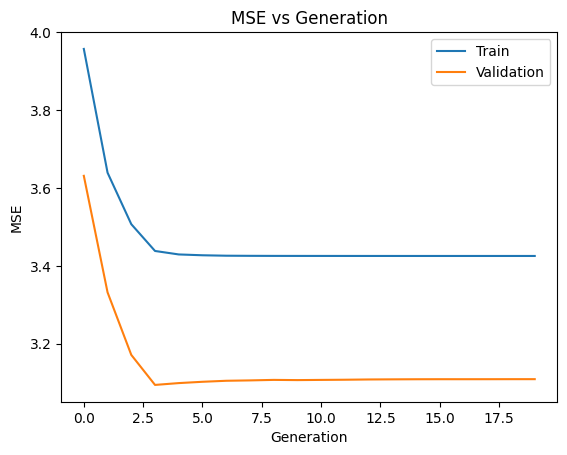

Train MSE: 3.4252412372475254, Validation MSE: 3.108786891427582


<Figure size 1400x800 with 0 Axes>

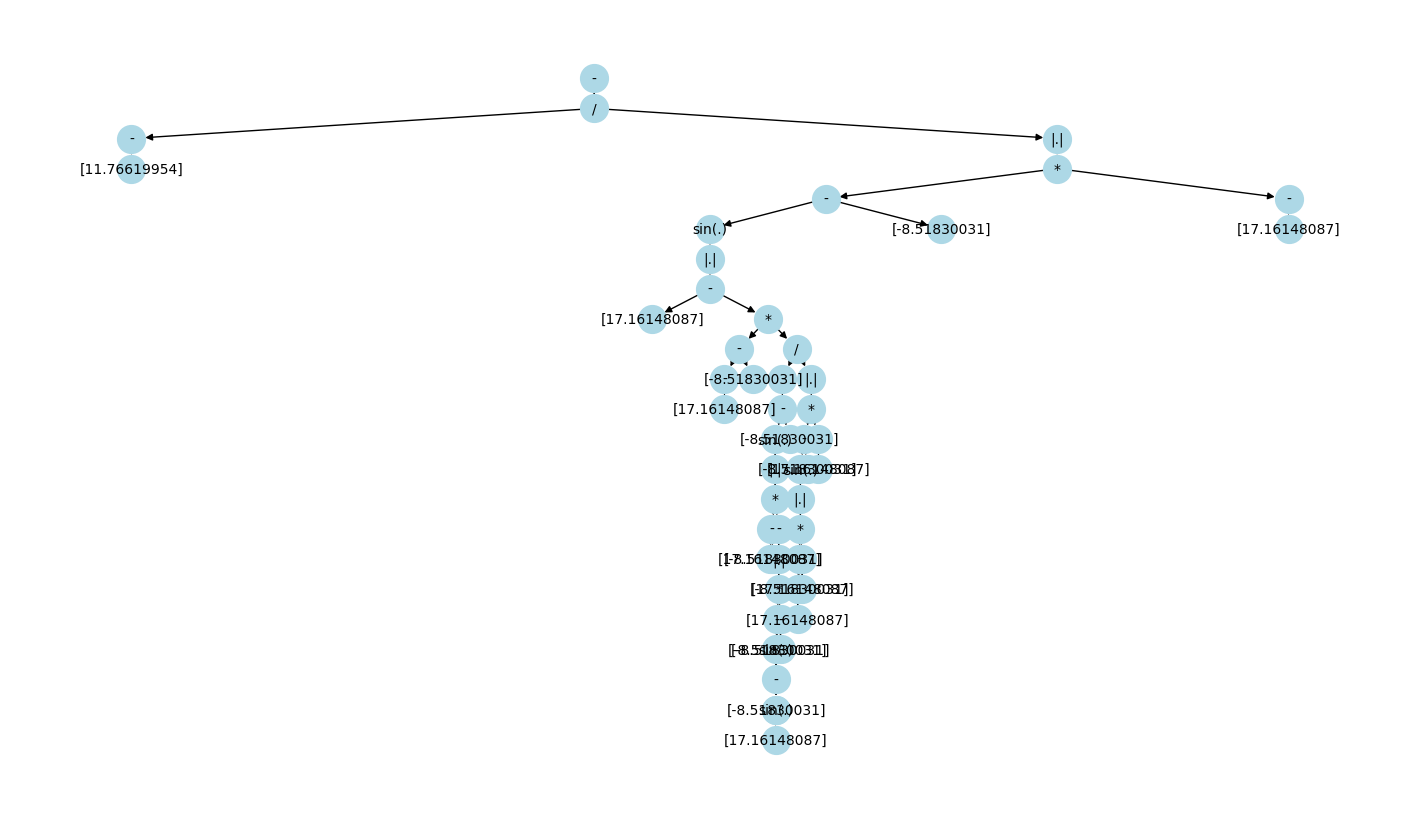

In [53]:
import matplotlib.pyplot as plt

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
champion = evolutionary_solve(population)

plt.figure(figsize=(14,8))
champion.genome.draw()
mse_val = Tree.mse(champion.genome, x_val, y_val)
print(f"Train MSE: {champion.mse}, Validation MSE: {mse_val}")

In [72]:
for operator in operators:
    print(operator.symbol, operator.function, operator.fanin)
    args = tuple(np.random.random() for _ in range(operator.fanin))
    operator.function(*args)

+ <built-in function add> 2
- <built-in function sub> 2
* <built-in function mul> 2
|.| <built-in function abs> 1
- <built-in function neg> 1
sign <ufunc 'sign'> 1
cbrt <ufunc 'cbrt'> 1
sin <ufunc 'sin'> 1
cos <ufunc 'cos'> 1
tan <ufunc 'tan'> 1
tanh <ufunc 'tanh'> 1


In [73]:
np.sin(np.tan(1.504))

np.float64(0.6884517773706234)

In [74]:
import inspect

numpy_operators = [getattr(np, obj) for obj in dir(np) if isinstance(getattr(np, obj), np.ufunc)]
print(numpy_operators)
[len(inspect.signature(op).parameters) for op in numpy_operators]
import operator
len(inspect.signature(operator.abs).parameters)


[<ufunc 'absolute'>, <ufunc 'absolute'>, <ufunc 'arccos'>, <ufunc 'arccosh'>, <ufunc 'add'>, <ufunc 'arccos'>, <ufunc 'arccosh'>, <ufunc 'arcsin'>, <ufunc 'arcsinh'>, <ufunc 'arctan'>, <ufunc 'arctan2'>, <ufunc 'arctanh'>, <ufunc 'arcsin'>, <ufunc 'arcsinh'>, <ufunc 'arctan'>, <ufunc 'arctan2'>, <ufunc 'arctanh'>, <ufunc 'bitwise_and'>, <ufunc 'bitwise_count'>, <ufunc 'invert'>, <ufunc 'left_shift'>, <ufunc 'invert'>, <ufunc 'bitwise_or'>, <ufunc 'right_shift'>, <ufunc 'bitwise_xor'>, <ufunc 'cbrt'>, <ufunc 'ceil'>, <ufunc 'conjugate'>, <ufunc 'conjugate'>, <ufunc 'copysign'>, <ufunc 'cos'>, <ufunc 'cosh'>, <ufunc 'deg2rad'>, <ufunc 'degrees'>, <ufunc 'divide'>, <ufunc 'divmod'>, <ufunc 'equal'>, <ufunc 'exp'>, <ufunc 'exp2'>, <ufunc 'expm1'>, <ufunc 'fabs'>, <ufunc 'float_power'>, <ufunc 'floor'>, <ufunc 'floor_divide'>, <ufunc 'fmax'>, <ufunc 'fmin'>, <ufunc 'fmod'>, <ufunc 'frexp'>, <ufunc 'gcd'>, <ufunc 'greater'>, <ufunc 'greater_equal'>, <ufunc 'heaviside'>, <ufunc 'hypot'>, <ufu

1